# K-means cluster plot
Data Analysis Python Pandas Data Manipulation Data Visualization K-means Clustering

Suppose you have the [following dataset](https://docs.google.com/spreadsheets/d/1DrvkAWnO1psWkFN1YVt891sHe4yHl4ljNPUVlCsI95M/edit#gid=2039795889) 
which contains (1st tab) a list of items purchased by a given user, (2nd tab) a mapping which maps the item_id to the item name and price, (3rd tab) a matrix that formats data from sheet 1 into a matrix with users in rows and the number of each item_id purchased in columns.

With this data, we want to see if we can cluster types of groceries that are typically purchased together. In a previous question, for this dataset, we wanted to build plots to look at n=3, 5, and 7. Knowing this, can you create a function that allows us to input the number of clusters and returns a plot with the potential clusters using Principal Component Analysis (PCA)?

See questions 143, 145, 151.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

filename = 'q143_output.csv'
df = pd.read_csv(filename)
df.set_index('user_id', inplace=True)
item_names = [
    "sugar","lettuce","pet items","baby items","waffles","poultry",
    "sandwich bags","butter","soda","carrots","cereals","shampoo",
    "bagels","eggs","aluminum foil","milk","beef","laundry detergent",
    "shaving cream","grapefruit","cheeses","frozen vegetables","tea",
    "paper towels","cherries","spaghetti sauce","dishwashing",
    "canned vegetables","hand soap","flour","pasta","apples",
    "toilet paper","tortillas","soap","ice cream","dinner rolls",
    "juice","sandwich loaves","berries","ketchup","cucumbers",
    "coffee","broccoli","cauliflower","bananas","pork","yogurt"
]
df.columns = item_names
print(df.shape)
df.head()

(24885, 48)


,sugar,lettuce,pet items,baby items,waffles,poultry,sandwich bags,butter,soda,carrots,...,sandwich loaves,berries,ketchup,cucumbers,coffee,broccoli,cauliflower,bananas,pork,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


C:\Users\tho\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


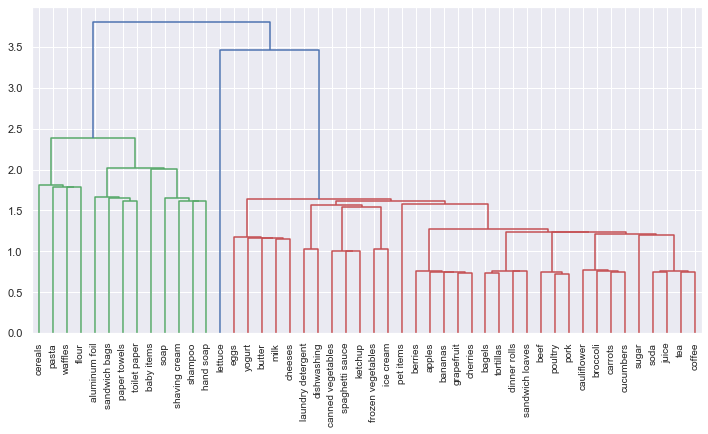

In [2]:
import scipy.cluster.hierarchy as hc
import scipy.spatial.distance as dist
import sklearn.metrics.pairwise as pw

# simple intro/example at https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/


def build_sim_matrix(df):
    labels = list(df.index)
    sim = pw.cosine_similarity(df)
    np.fill_diagonal(sim, np.nan)
    return sim, labels
    
    
def build_linkage(sim, method='single'):
    """
    method can single, centroid, median, complete, etc
    see docs for scipy.cluster.hierarchy.linkage
    
    recipe from https://gist.github.com/tommct/c3ffca76251aba2351da7e3b1183bf5a
    """
    distances = 1 - sim # so that 0 is close and 1 is far.
    np.fill_diagonal(distances, 0)
    distances = np.clip(distances, 0, 1)
    dists = dist.squareform(dist.pdist(distances, 'sqeuclidean'))
    links = hc.linkage(dists, method=method)
    return links


def plot_dendrogram(linkage, labels):
    """
    plot dendrogram given the linkage matrix 
    returned by scipy.cluster.hierarchy.linkage
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    dd = hc.dendrogram(linkage, labels=labels, ax=ax)
    ax.tick_params(axis='x', which='major', labelsize=10)

    
similarity_matrix, labels = build_sim_matrix(df.T)
links = build_linkage(similarity_matrix)
plot_dendrogram(links, labels)


In [3]:
def get_cluster_labels(links, n_clusters):
    """ 
    links: linkage matrix, size n by 4
    n_clusters: integer >= 2
    returns integer array of size n, indicating cluster for this point
    """
    low, high = links[-n_clusters,2], links[-n_clusters+1,2]
    threshold = (low + high)/2
    return hc.fcluster(links, threshold, criterion='distance')

clusters = get_cluster_labels(links, 2)
pd.DataFrame({'item':df.columns, 'cluster': clusters}).sort_values(by='cluster').head()


,item,cluster
23,paper towels,1
29,flour,1
30,pasta,1
3,baby items,1
4,waffles,1


In [4]:
from sklearn.decomposition import PCA

def build_pca(df):
    pca = PCA() # as many components as there are features
    pca.fit(df)
    df_pca = pca.transform(df)
    return pca, df_pca

pca, df_pca = build_pca(df)
print(pca.explained_variance_ratio_[:10]) # top 10 components

[0.1486854  0.04044879 0.03715107 0.03636788 0.03236198 0.02745954
 0.02657785 0.02460473 0.02314124 0.02098734]


# option 1: display hierarchical clusters in PCA space

Build clusters hierarchically,
then run PCA,
then plot clusters in 2d PCA space.

This leads to clusters potentially overlapping a lot.

Note: no use of Kmeans here.

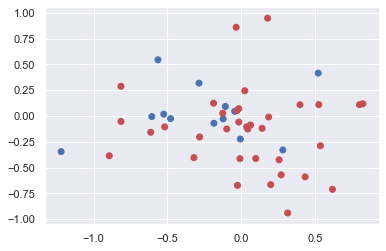

In [5]:
def cluster_and_plot_in_pca(df, df_pca, n_clusters=2):
    clusters = get_cluster_labels(links, n_clusters)
    colors = np.choose(clusters-1,['b','r','g','y','k','m','c'])
    plt.scatter(df_pca[:1],df_pca[1:2], c=colors)

    
cluster_and_plot_in_pca(df,df_pca,2)

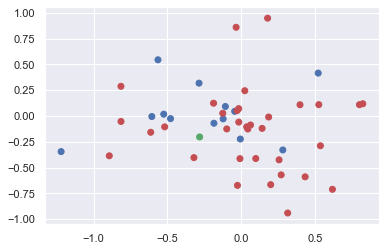

In [6]:
cluster_and_plot_in_pca(df,df_pca,3)

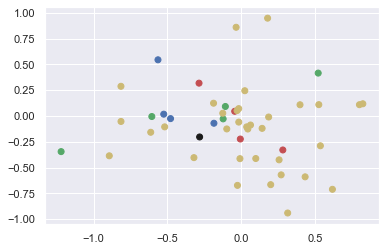

In [7]:
cluster_and_plot_in_pca(df,df_pca,5)

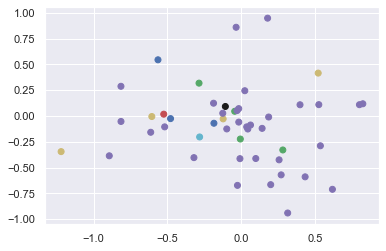

In [8]:
cluster_and_plot_in_pca(df,df_pca,7)

# option 2: PCA then Kmeans

First PCA, then kmeans in PCA space, then plot in PCA space.

Running kmeans in the same space we plot reduces cluster overlap in the graphs.
But it does not mean the clusters are better.

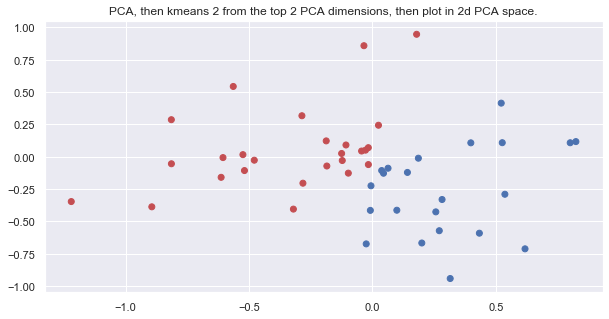

In [9]:
from sklearn.cluster import KMeans

def kmeans_cluster_and_plot_in_pca(df, df_pca, n_clusters=2, n_pca_dims=2):
    """
    n_clusters: number of clusters returned by kmeans.
    n_pca_dims: number of PCA dimensions to use when clustering with kmeans.
        Keeping this at 2 results in non-overlapping graphs in 2d plots.
        Can play with this if need be.
    """
    # clusters = get_cluster_labels(links, n_clusters)
    data = df_pca[:n_pca_dims].T # so the clusters look nice and don't overlap in 2d plot
    kmeans = KMeans(n_clusters, random_state=0).fit(data)
    clusters = list(kmeans.labels_)
    colors = np.choose(clusters,['b','r','g','y','k','m','c'])
    x = df_pca[0]
    y = df_pca[1]
    plt.figure(figsize=(10,5))
    plt.scatter(x, y, c=colors)
    title = f'PCA, then kmeans {n_clusters} from the top {n_pca_dims} PCA dimensions, then plot in 2d PCA space.'
    plt.title(title)

kmeans_cluster_and_plot_in_pca(df, df_pca, 2)

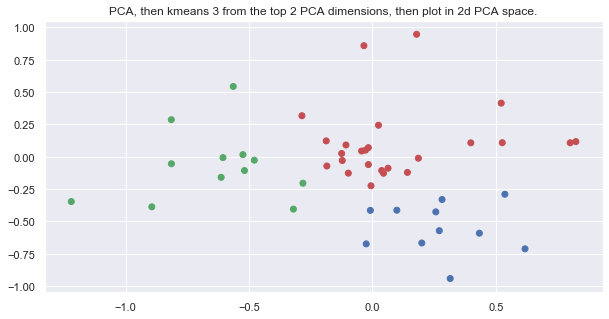

In [10]:
kmeans_cluster_and_plot_in_pca(df, df_pca, 3)


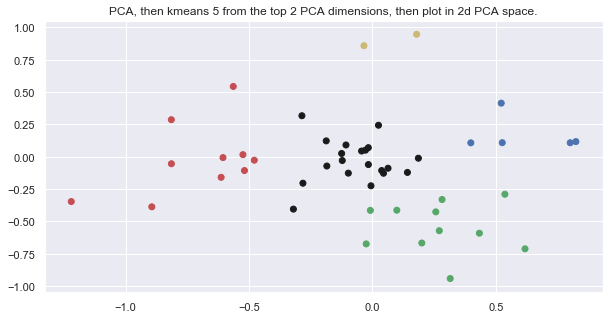

In [11]:
kmeans_cluster_and_plot_in_pca(df, df_pca, 5)

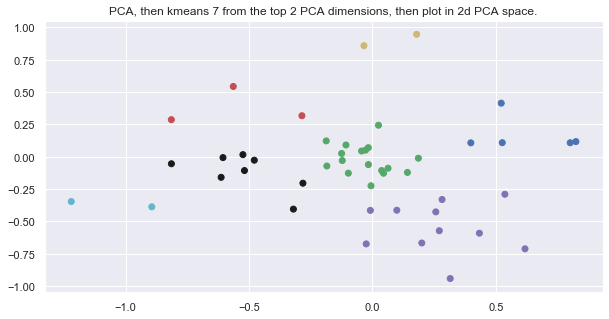

In [12]:
kmeans_cluster_and_plot_in_pca(df, df_pca, 7)

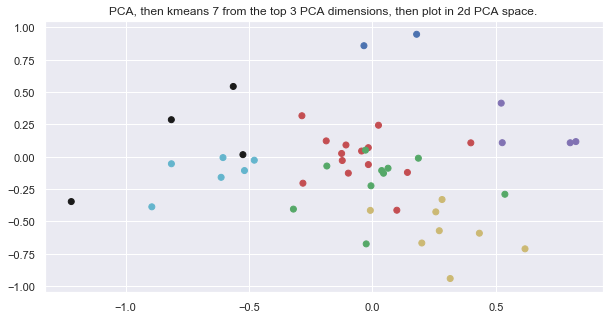

In [13]:
kmeans_cluster_and_plot_in_pca(df, df_pca, 7, 3)